<a href="https://colab.research.google.com/github/allen44/riiid-test-answer-prediction/blob/main/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



#Import the data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train.csv', index_col='row_id')

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


#Examine the shape of the dataframe, summary statistics, and missing values

In [3]:
info_fullset = df.info()
info_fullset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101230332 entries, 0 to 101230331
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int64  
 2   content_id                      int64  
 3   content_type_id                 int64  
 4   task_container_id               int64  
 5   user_answer                     int64  
 6   answered_correctly              int64  
 7   prior_question_elapsed_time     float64
 8   prior_question_had_explanation  object 
dtypes: float64(1), int64(7), object(1)
memory usage: 7.5+ GB


In [4]:
df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,NaN
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False


In [5]:
df.shape

(101230332, 9)

In [6]:
describe_fullset = df.describe(include='all')
describe_fullset

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
count,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,9.887879e+07,100837826
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89685560
mean,7.703644e+09,1.076732e+09,5.219605e+03,1.935222e-02,9.040624e+02,1.376123e+00,6.251644e-01,2.542381e+04,NaN
std,1.159266e+10,6.197163e+08,3.866359e+03,1.377596e-01,1.358302e+03,1.192896e+00,5.225307e-01,1.994815e+04,NaN
min,0.000000e+00,1.150000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,NaN
25%,5.243436e+08,5.408116e+08,2.063000e+03,0.000000e+00,1.040000e+02,0.000000e+00,0.000000e+00,1.600000e+04,NaN
50%,2.674234e+09,1.071781e+09,5.026000e+03,0.000000e+00,3.820000e+02,1.000000e+00,1.000000e+00,2.100000e+04,NaN
75%,9.924551e+09,1.615742e+09,7.425000e+03,0.000000e+00,1.094000e+03,3.000000e+00,1.000000e+00,2.966600e+04,NaN


##Check for missing data

In [7]:
# Count missing values
df.isna().sum()

timestamp                               0
user_id                                 0
content_id                              0
content_type_id                         0
task_container_id                       0
user_answer                             0
answered_correctly                      0
prior_question_elapsed_time       2351538
prior_question_had_explanation     392506
dtype: int64

The data is mostly clean, and only two columns have missing data. Based on the names of these two columns, it seems well have to take a closer look at these two later before handling the missing data.

##Check unique entries and dtypes

In [8]:
#Check the relative frequency of unique values in each column
df.nunique()

timestamp                         72821015
user_id                             393656
content_id                           13782
content_type_id                          2
task_container_id                    10000
user_answer                              5
answered_correctly                       3
prior_question_elapsed_time           3258
prior_question_had_explanation           2
dtype: int64

## Changing dtypes
As the number of unique entries in each column is comparatively low, relative to the size of the data set, there will be perfomance gains by recaasting most of these colums as categorical variables.

timestamp and prior_question_elapsed_time            is an exception and should be treated differently.

prior_question_elapsed_time is a float and probably should not be categorical.

prior_question_had_explanation should be change to dtype:bool


In [9]:
categorical_columns = ['user_id', 'content_id', 'content_type_id', 'task_container_id', 'user_answer', 'answered_correctly']
for column_id in categorical_columns:
  df[column_id] = pd.Categorical(df[column_id])

df['prior_question_had_explanation'] = df['prior_question_had_explanation'].astype('bool')
df.dtypes

timestamp                            int64
user_id                           category
content_id                        category
content_type_id                   category
task_container_id                 category
user_answer                       category
answered_correctly                category
prior_question_elapsed_time        float64
prior_question_had_explanation        bool
dtype: object

# Exploring the data in each column

From the Kaggle website:


row_id: (int64) ID code for the row.

timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.

user_id: (int32) ID code for the user.

content_id: (int16) ID code for the user interaction

content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.

user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.

answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.

prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.

prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.





##timestamp

Presumably, this column has something to do with time, but need not be a time series. Let plot to see the distribution of the data, along with summary statistics.

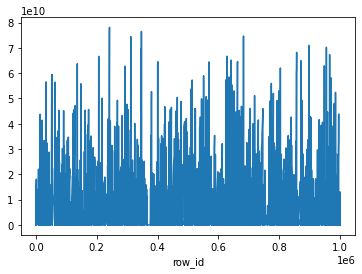

In [49]:
df['timestamp'].plot()
plt.show()

A line plot shows no useful info

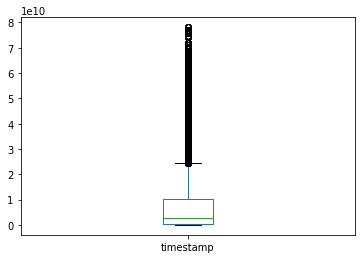

In [50]:
df['timestamp'].plot(kind='box')
plt.show()

A box plot shows that that the timestamps generally have values between 0e9 and 2e9, with a minority of values larger than 2.

As 10e8 is about 3.1 years, and 10e7 is about 0.31 years,

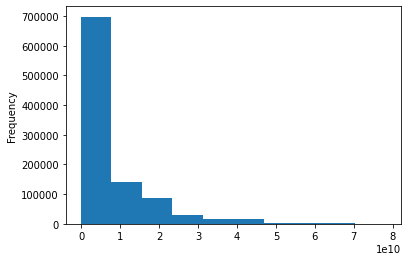

In [51]:
df['timestamp'].plot(kind='hist', bins=10)
plt.show()

There is a right-skewness but no reason yet to consider these as outliers to drop or correct.

Most of the data entries were from relatively "young" user accounts, while a minority of data are from older user accounts. The units here are milliseconds since account creations, so the average action took place about 0.23 years after account creation.

##user_id

This is presumed to a unique user id that is randomly distributed to each user, with one per user.

This data can be used to relate data etries from the same users through out the data set.


In [52]:
#Count the unique users in this data set
unique_users = df['user_id'].unique()
unique_users

[115, 124, 2746, 5382, 8623, ..., 20913319, 20913864, 20938253, 20948951, 20949024]
Length: 3824
Categories (3824, int64): [115, 124, 2746, 5382, ..., 20913864, 20938253, 20948951, 20949024]

unique_users is an np.array of types int, buit is not continuous and very few of the numbers in the range are used.

In [53]:
len(unique_users)

3824

As there are not that many users, while the int range is large, there may be a performance benefit to convert this data type to Category.

In [54]:
df['user_id'] = df['user_id'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                          Non-Null Count    Dtype   
---  ------                          --------------    -----   
 0   timestamp                       1000000 non-null  int64   
 1   user_id                         1000000 non-null  category
 2   content_id                      1000000 non-null  category
 3   content_type_id                 1000000 non-null  category
 4   task_container_id               1000000 non-null  category
 5   user_answer                     1000000 non-null  category
 6   answered_correctly              1000000 non-null  category
 7   prior_question_elapsed_time     976277 non-null   float64 
 8   prior_question_had_explanation  1000000 non-null  bool    
dtypes: bool(1), category(6), float64(1), int64(1)
memory usage: 33.7 MB


We can see that the user_id column now has dtype: category.

We can  group the rows by user_id now by using a multi-index

In [55]:
df = df.set_index('user_id', 'timestamp')
df.head()

,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,
115,0,5692,0,1,3,1,NaN,True
115,56943,5716,0,2,2,1,37000.0,False
115,118363,128,0,0,0,1,55000.0,False
115,131167,7860,0,3,0,1,19000.0,False
115,137965,7922,0,4,1,1,11000.0,False


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 1000000 entries, 115 to 20949024
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype   
---  ------                          --------------    -----   
 0   timestamp                       1000000 non-null  int64   
 1   content_id                      1000000 non-null  category
 2   content_type_id                 1000000 non-null  category
 3   task_container_id               1000000 non-null  category
 4   user_answer                     1000000 non-null  category
 5   answered_correctly              1000000 non-null  category
 6   prior_question_elapsed_time     976277 non-null   float64 
 7   prior_question_had_explanation  1000000 non-null  bool    
dtypes: bool(1), category(5), float64(1), int64(1)
memory usage: 26.1 MB


In [57]:
df.shape

(1000000, 8)

We see that there is only less column now.

##Detour
As the Google Colab runtime keeps crashing due to lack of memory (even with Colab Pro), we will switch to importing only about 1% of the data for this EDA. IF we see that this subset differs signifcant;y fullset's summary statistics, we can contiue to attempt using the full set.

In [58]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train.csv', index_col='row_id', nrows=10**6)

In [59]:
info_subset = df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   timestamp                       1000000 non-null  int64  
 1   user_id                         1000000 non-null  int64  
 2   content_id                      1000000 non-null  int64  
 3   content_type_id                 1000000 non-null  int64  
 4   task_container_id               1000000 non-null  int64  
 5   user_answer                     1000000 non-null  int64  
 6   answered_correctly              1000000 non-null  int64  
 7   prior_question_elapsed_time     976277 non-null   float64
 8   prior_question_had_explanation  996184 non-null   object 
dtypes: float64(1), int64(7), object(1)
memory usage: 76.3+ MB


In [60]:
#Redo the earlier transformations
categorical_columns = ['user_id', 'content_id', 'content_type_id', 'task_container_id', 'user_answer', 'answered_correctly']
for column_id in categorical_columns:
  df[column_id] = pd.Categorical(df[column_id])

df['prior_question_had_explanation'] = df['prior_question_had_explanation'].astype('bool')
df.dtypes

timestamp                            int64
user_id                           category
content_id                        category
content_type_id                   category
task_container_id                 category
user_answer                       category
answered_correctly                category
prior_question_elapsed_time        float64
prior_question_had_explanation        bool
dtype: object

In [61]:
describe_subset = df.describe(include='all')
describe_subset

KeyboardInterrupt: ignored

##content_id

How many different content_id are there? How often does the most common content_ID occur? Does any small group of content_ids form a disproportionate amount of the events?

In [67]:
#Count the unique content_ids and describe the distribution of the counts
df['content_id'].value_counts().describe()

count    13320.000000
mean        75.075075
std        113.408037
min          1.000000
25%         22.000000
50%         49.000000
75%         86.000000
max       2041.000000
Name: content_id, dtype: float64

In [68]:
#Same function, but normalized
df['content_id'].value_counts(normalize=True).describe()

count    13320.000000
mean         0.000075
std          0.000113
min          0.000001
25%          0.000022
50%          0.000049
75%          0.000086
max          0.002041
Name: content_id, dtype: float64

We see 13320 unique content ids.

The most common content_id occured only 0.2% of the time. The average content_id occurs about 0.007% of the time.

It may be useful to consider these in groups, because any single content_id is such a small part of the whole set.


##content_type_id



In [63]:
#Count the unique content_type_ids and describe the distribution of the counts
df['content_type_id'].value_counts()

0    980093
1     19907
Name: content_type_id, dtype: int64

We note that ther are only two content_id_types.

`content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.`

Around 2% of the data is the user watching a lecture. Mos tof the data is a question posed to the user.

##task_container_id

*italicized text*

In [65]:
#Count the unique task_container_id and describe the distribution of the counts
df['task_container_id'].value_counts().describe()

count    7740.000000
mean      129.198966
std       359.676483
min         1.000000
25%         1.000000
50%        23.000000
75%       104.000000
max      7845.000000
Name: task_container_id, dtype: float64

In [74]:
temp = df['task_container_id'].value_counts(normalize=True)
temp

14      0.007845
15      0.007806
4       0.006753
5       0.006732
6       0.006722
          ...   
6327    0.000001
6326    0.000001
6325    0.000001
6324    0.000001
7739    0.000001
Name: task_container_id, Length: 7740, dtype: float64

<BarContainer object of 7740 artists>

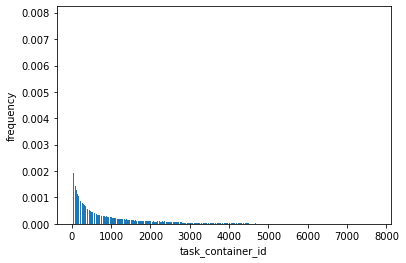

In [75]:
#Count the unique task_container_id and describe the distribution of the counts
plt.ylabel('frequency')
plt.xlabel('task_container_id')
plt.bar(temp.index, temp.values)

It's notable that the task_container_ids with the lowest numbers tend to occur most frequently. Perhaps these id were not randomly assigned from a hash but were assigned sequentially.

It could be useful to dig in to the docs and find if certain task_container_ids have further meaning which could be useful in feature engineering.

##user_answer

`user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.`


In [80]:
#Count the unique task_container_id and describe the distribution of the counts
df['user_answer'].value_counts()

0     278205
1     267017
3     257932
2     176939
-1     19907
Name: user_answer, dtype: int64

In [82]:
temp_2 = df['user_answer'].value_counts(normalize=True)
temp_2

0     0.278205
1     0.267017
3     0.257932
2     0.176939
-1    0.019907
Name: user_answer, dtype: float64

It looks like the these are multiple choice answers. Of the 4 nonlecture types, it looks like there is a negative bias on category 2. That is, users answer '2' less often then expected from chance alone. It could be that the users are inherently biased aginast answering with  '2', or possibly, the questions creators are have biased questions so that users are less likely to select '2', or it could be something else. 

We may have to transform this column later so that the '-1' values are not in this coloumn, depending on the requirements of the pipelines we use later. An easy transform might be to asssign NaN to these '-1' values.

##answered_correctly

`answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.`

In [85]:
#Count the unique task_container_id and describe the distribution of the counts
df['answered_correctly'].value_counts()

1     637411
0     342682
-1     19907
Name: answered_correctly, dtype: int64

In [87]:
#Check the frequency of each count
df['answered_correctly'].value_counts(normalize=True)

1     0.637411
0     0.342682
-1    0.019907
Name: answered_correctly, dtype: float64

The '-1' occurs here exactly as frequent as in user_answer. It might be best to seperate the lecture rows entirtely from the rest of the dataframe, rather than transform it.

##prior_question_elapsed_time

`prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.`

It might be possible to determine each user's first lecture from this point alone.


Note that is 

In [105]:
#Count the unique prior_question_elapsed_time and describe the distribution of the counts
prior_question_elapsed_time = df['prior_question_elapsed_time']
prior_question_elapsed_time.value_counts()

17000.0     50744
16000.0     46949
18000.0     46550
19000.0     39580
15000.0     35889
            ...  
144600.0        1
254667.0        1
99333.0         1
146200.0        1
124600.0        1
Name: prior_question_elapsed_time, Length: 1659, dtype: int64

In [106]:
#Check the frequency of each count
prior_question_elapsed_time.value_counts(normalize=True)


17000.0     0.051977
16000.0     0.048090
18000.0     0.047681
19000.0     0.040542
15000.0     0.036761
              ...   
144600.0    0.000001
254667.0    0.000001
99333.0     0.000001
146200.0    0.000001
124600.0    0.000001
Name: prior_question_elapsed_time, Length: 1659, dtype: float64

Well, this looks peculiar. The top 5 value counts are 17.000 seconds, 16.000 seconds, 18.000 seconds, 19.000 seconds, and 15.000. The units is milliseconds, but these top five values appear to either have been rounded to the nearest second, or the students are machinely-like in their precision of submitting the answer on the exact milliseconds so that the delay is multiple of 1000 millisenconds. 

Alternatively, an automated tool, like a test-taking bot--designed to harvest test questions by guessing any answer while scraping the question content to store in a database for use later--has been answering questions with a simulated delay that can be modeled by a discrete normal distribution with mean 17000. The magnitude of this hypoithesized automnation is such that around 20% of all answers submitted could fit this model.

Cross-referencing user_ids connected to these anomolus prior_question_elapsed_time values could lend support to the hypothesis if there are a small number of user ids who make a disprotionate amount of all answers.

If the hypothesis is true,
It may be useful later to feature-engineer these automated users (bots) into their own column or dataframe, as their behavior could be quite different from the human users. It may be easier to model the responses of the bots seperately from the humans.

An alternative explanation could be that, assuming this educational platform is accessed via a web browser, some web browsers may round times  to whole-number of seconds. It unlikely though. Also, this fails to address the simulated discrete normal distribution about 17.000 seconds.

Let's continue without seperating the two populations for now...

In [107]:
prior_question_elapsed_time.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            999990, 999991, 999992, 999993, 999994, 999995, 999996, 999997,
            999998, 999999],
           dtype='int64', name='row_id', length=1000000)

In [108]:
prior_question_elapsed_time.describe()

count    976277.000000
mean      25302.962693
std       19710.310227
min           0.000000
25%       16000.000000
50%       21000.000000
75%       29666.000000
max      300000.000000
Name: prior_question_elapsed_time, dtype: float64

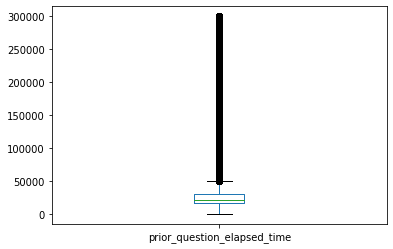

In [110]:
prior_question_elapsed_time.plot(kind='box')

Mean time to asnwers the last question is about 25 seconds; the median is 21.000 seconds.

The effect of the hypothesized bot subpopulation is large enough that it is convolutes our summary statistics on the whole population. We see that the 25th-percentile and median are 16.000 seconds and 21.000 seconds. 

It looks like there a hard cutoff on answer times at 5 minutes (300000 milliseconds).

We might have to discard answers given with delay 0, as I don't know what they mean yet.


##prior_question_had_explanation

`prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.`